Sheet 6.2: Character-level sequence modeling w/ LSTMs
=====================================================

**Author:** Michael Franke



This tutorial builds on the earlier tutorial (5.1) which implemented a character-level RNN.
Previously we implemented the RNN model without making use of PyTorch&rsquo;s built-in functions.
In this tutorial, we will implement an LSTM using these convenient functions.
Applying the new LSTM model to the exact same data (surname predictions for different countries), we can compare the efficiency and power of the two architectures.



Student: Jia Sheng (5371477)

## Packages & global parameters



Imports as before in (5.1).



In [1]:
##################################################
## import packages
##################################################

from __future__ import unicode_literals, print_function, division
from io import open
import json
import glob
import os
import unicodedata
import pandas
import string
import torch
import urllib.request
import numpy as np
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Load & pre-process data



Loading and pre-processing the data is also as before in sheet 5.1.



In [2]:
##################################################
## read and inspect the data
##################################################
with urllib.request.urlopen("https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/05-RNNs/names-data.json") as url:
     namesData = json.load(url)

# with open('names-data.json') as dataFile:
#     namesData = json.load(dataFile)

categories = list(namesData.keys())
n_categories   = len(categories)

# we use all ASCII letters as the vocabulary (plus tokens [EOS], [SOS])
all_letters = string.ascii_letters + " .,;'-"
n_letters   = len(all_letters) + 2 # all letter plus [EOS] and [SOS] token
SOSIndex    = n_letters - 1
EOSIndex    = n_letters - 2

##################################################
## make a train/test split
##################################################

train_data = dict()
test_data  = dict()
split_percentage = 10
for k in list(namesData.keys()):
    total_size    = len(namesData[k])
    test_size     = round(total_size/split_percentage)
    train_size    = total_size - test_size
    print(k, total_size, train_size, test_size)
    indices       = [i for i in range(total_size)]
    random.shuffle(indices)
    train_indices = indices[0:train_size]
    test_indices  = indices[(train_size+1):(-1)]
    train_data[k] = [namesData[k][i] for i in train_indices]
    test_data[k]  = [namesData[k][i] for i in test_indices]

Czech 519 467 52
German 724 652 72
Arabic 2000 1800 200
Japanese 991 892 99
Chinese 268 241 27
Vietnamese 73 66 7
Russian 9408 8467 941
French 277 249 28
Irish 232 209 23
English 3668 3301 367
Spanish 298 268 30
Greek 203 183 20
Italian 709 638 71
Portuguese 74 67 7
Scottish 100 90 10
Dutch 297 267 30
Korean 94 85 9
Polish 139 125 14


## Define LSTM module



The definition of the LSTM model follows the steps explained in the previous worksheet (6.1) closely.
NB: we include a dropout rate (which here acts in between layers of the stacked LSTM).



In [3]:
##################################################
## define LSTM
##################################################

class LSTM(nn.Module):
    def __init__(self, cat_embedding_size, n_cat,
                 char_embedding_size, n_char,
                 hidden_size, output_size, num_layers = 2, dropout = 0.1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        # category embedding
        self.cat_embedding = nn.Embedding(n_cat, cat_embedding_size)
        # character embedding
        self.char_embedding = nn.Embedding(n_char, char_embedding_size)
        # the actual LSTM
        self.lstm = nn.LSTM(input_size  = cat_embedding_size+char_embedding_size,
                            hidden_size = hidden_size,
                            num_layers  = num_layers,
                            batch_first = True,
                            dropout = dropout
                            )
        # linear map onto weights for words
        self.linear_map = nn.Linear(hidden_size, output_size)

    def forward(self, category, name, hidden):
        cat_emb  = self.cat_embedding(category)
        char_emb = self.char_embedding(name)
        output, (hidden, cell) = self.lstm(torch.concat([cat_emb, char_emb], dim = 1))
        predictions = self.linear_map(output)
        return torch.nn.functional.log_softmax(predictions, dim = 1), hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 6.2.1: </span></strong>
>
> 1. How is the category information supplied to next network? I.e.,, what is the input format and how is this information made accessible for computation at every word?
>
> 2. What exactly is the return value of a single forward pass?



#### Answers: 
**Exercise 6.2.1.1**

- The category information was a embedding matrix consisting of vectors of embeddings, the size of each vector is specified as cat_embedding_size.
- The size of this embedding matrix is the same as the number of characters in the name, i.e. the embedding vector is repeated in this matrix as many times as the length of the random string name in this random training pair. 
- Then, the category embedding matrix is concatenated to the character embedding matrix and passed to the LSTM function, so that each character has access to the category information.


**Exercise 6.2.1.2**

- The output of the LSTM function consists of the last layer of each character embeddings, the hidden state of all layers of the last character, and the cell state of all layers of the last character.
- Then, within the forward function, the embeddings of the last layer of each character embedding is mapped to a vector of weights (predictions) of the same length as the size of all letters.
- These predictions are then normalized by a softmax function and turned into the next-character probabilities, that is, each character is represented as a probability value of it being the next character. Along with the hidden state of all layers of the last character it composed the return value of this single forward pass.


In [4]:
# inspect the embedding output
cat_embedding = nn.Embedding(18, 32)
cat_embedding(torch.tensor([4, 4, 4, 4, 4]))


tensor([[ 1.8047,  0.0885,  0.4692,  0.5301,  1.1307, -0.6709,  1.4770, -1.3666,
          0.4251, -0.1662,  1.0761,  1.3686, -0.3516, -0.9902,  0.9859, -1.0888,
          0.2001, -0.6627,  1.8545,  0.4255, -0.2603,  1.7848,  0.5559, -1.2131,
         -0.5495, -1.1968, -2.4137,  0.0458,  0.2493,  0.3542,  0.8570,  0.2510],
        [ 1.8047,  0.0885,  0.4692,  0.5301,  1.1307, -0.6709,  1.4770, -1.3666,
          0.4251, -0.1662,  1.0761,  1.3686, -0.3516, -0.9902,  0.9859, -1.0888,
          0.2001, -0.6627,  1.8545,  0.4255, -0.2603,  1.7848,  0.5559, -1.2131,
         -0.5495, -1.1968, -2.4137,  0.0458,  0.2493,  0.3542,  0.8570,  0.2510],
        [ 1.8047,  0.0885,  0.4692,  0.5301,  1.1307, -0.6709,  1.4770, -1.3666,
          0.4251, -0.1662,  1.0761,  1.3686, -0.3516, -0.9902,  0.9859, -1.0888,
          0.2001, -0.6627,  1.8545,  0.4255, -0.2603,  1.7848,  0.5559, -1.2131,
         -0.5495, -1.1968, -2.4137,  0.0458,  0.2493,  0.3542,  0.8570,  0.2510],
        [ 1.8047,  0.0885

## Helper functions for training



Again, the following training functions are similar to what we used in sheet 5.1, but changed to handle the different representational format of the input.
(Previous work sheet used a one-hot vector representation where we here use an index (integer) representation for each word.)



In [4]:
##################################################
## helper functions for training
##################################################

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random name from that category
def randomTrainingPair():
    category = randomChoice(categories)
    name = randomChoice(train_data[category])
    return category, name

# get index representation of name (in the proper format)
def getNameIndices(name):
    indices = [SOSIndex] + [all_letters.index(c) for c in list(name)] + [EOSIndex]
    return indices

# get index representation of category (in the proper format)
# NB: must have same length as corresponding name representation b/c
#     each character in the sequence is concatenated with the category information
def getCatIndices(category, name_length):
    return torch.full((1,name_length), categories.index(category)).reshape(-1)

# get random training pair in desired input format (vectors of indices)
def randomTrainingExample():
    category, name = randomTrainingPair()
    name_length = len(name) + 2
    return getCatIndices(category, name_length), torch.tensor(getNameIndices(name))

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
getNameIndices("Sheng")

[59, 44, 7, 4, 13, 6, 58]

In [ ]:
getCatIndices("English", 7)

tensor([9, 9, 9, 9, 9, 9, 9])

In [6]:
randomTrainingExample()

(tensor([16, 16, 16, 16, 16]), tensor([59, 50, 14, 14, 58]))

In [22]:
print(len(all_letters))

58


## Single training step



A single training loop for a single pair of category and name considers the output predictions of the LSTM.
The way we defined the LSTM above makes it so that the first component that is returned feeds directly in to the loss function (negative log likeihood).



In [5]:
##################################################
## single training pass
##################################################

def train(cat, name):
    # get a fresh hidden layer
    hidden = lstm.initHidden()
    # zero the gradients
    optimizer.zero_grad()
    # run sequence
    predictions, hidden = lstm(cat, name, hidden)
    # compute loss (NLLH)
    loss = criterion(predictions[:-1], name[1:len(name)])
    # perform backward pass
    loss.backward()
    # perform optimization
    optimizer.step()
    # return prediction and loss
    return loss.item()

## Model instantiation & training loop



The LSTM we instantiate here is rather smallish.
It has only one layer, a hidden and cell state of size 64 and uses an embedding size of 32 for both categories and names.



In [6]:
##################################################
## actual training loop
## (should take about 1-2 minutes)
##################################################

# instantiate model
lstm = LSTM(cat_embedding_size  = 32,
            n_cat               = n_categories,
            char_embedding_size = 32,
            n_char              = n_letters,
            hidden_size         = 64,
            output_size         = n_letters,
            dropout             = 0,
            num_layers          = 1
            )
# training objective
criterion = nn.NLLLoss(reduction='sum')
# learning rate
learning_rate = 0.005
# optimizer
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# training parameters
n_iters = 50000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # will be reset every 'plot_every' iterations

start = time.time()

for iter in range(1, n_iters + 1):
    loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

    if iter % print_every == 0:
        rolling_mean = np.mean(all_losses[iter - print_every*(iter//print_every):])
        print('%s (%d %d%%) %.4f' % (timeSince(start),
                                     iter,
                                     iter / n_iters * 100,
                                     rolling_mean))

0m 15s (5000 10%) 16.9360
0m 31s (10000 20%) 16.0445
0m 46s (15000 30%) 15.5689
1m 3s (20000 40%) 15.2217
1m 20s (25000 50%) 15.0159
1m 37s (30000 60%) 14.8340
1m 52s (35000 70%) 14.6694
2m 8s (40000 80%) 14.5188
2m 24s (45000 90%) 14.4107
2m 40s (50000 100%) 14.3063


## Plotting training performance



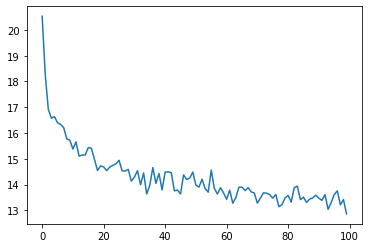

In [7]:
##################################################
## monitoring loss function during training
##################################################

plt.figure()
plt.plot(all_losses)
plt.show()

## Evaluation



Extraction of surprisal of a single item and computation of average surprisal for test and training set is largely parallel to the case of sheet 5.1.



In [8]:
##################################################
## evaluation
##################################################

def get_surprisal_item(category, name):
    name      = torch.tensor(getNameIndices(name))
    cat       = getCatIndices(category,len(name))
    hidden    = lstm.initHidden()
    prediction, hidden = lstm(cat, name, hidden)
    nll       = criterion(prediction[:-1], name[1:len(name)])
    return(nll.item())

def get_surprisal_dataset(data):
    surprisl_dict = dict()
    surp_avg_dict = dict()
    perplxty_dict = dict()
    for category in list(data.keys()):
        surprisl = 0
        surp_avg = 0
        perplxty = 0
        # training
        for name in data[category]:
            item_surpr = get_surprisal_item(category, name)
            surprisl  += item_surpr
            surp_avg  += item_surpr / len(name)
            perplxty  += item_surpr ** (-1 / len(name))
        n_items = len(data[category])

        surprisl_dict[category] = (surprisl /n_items)
        surp_avg_dict[category] = (surp_avg / n_items)
        perplxty_dict[category] = (perplxty / n_items)

    return(surprisl_dict, surp_avg_dict, perplxty_dict)

def makeDF(surp_dict):
    p = pandas.DataFrame.from_dict(surp_dict)
    p = p.transpose()
    p.columns = ["surprisal", "surp_scaled", "perplexity"]
    return(p)

surprisal_test  = makeDF(get_surprisal_dataset(test_data))
surprisal_train = makeDF(get_surprisal_dataset(train_data))

print("\nmean surprisal (test):", np.mean(surprisal_test["surprisal"]))
print("\nmean surprisal (train):", np.mean(surprisal_train["surprisal"]))


mean surprisal (test): 16.04405969481709

mean surprisal (train): 13.403144764069278


> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 6.2.2: Interpret the evaluation metrics </span></strong>
>
> 1. What do you conclude from these two numbers? Is there a chance that the model overfitted the training data?
>
> 2. What do you conclude about the performance of the RNN (from sheet 5.1) and the current LSTM implementation? Which model is better?



#### Answers:

**Exercise 6.2.2.1**

- These two numbers represent the average surprisal (cross entropy) of the predictions made by trained model for different input data, when the true distribution is the data from the given dataset. The lower this value, the closer the model predictions are to the true distribution. The average surprisal of train data is lower than that of the test data, suggesting that this model performs better at predicting train data than test data.
- There is a chance that the model overfitted the training data, because the average surprisal of train data is muss smaller than the test data, meaning the model performs worse on unseen data than seen data, which indicates overfitting.

**Exercise 6.2.2.2**

- If we compare the average surprisal of train data, the current LSTM has better performance. The average surprisal of train data by RNN model was 16.6, while by the current model is 13.2, which means the LSTM model's predictions on the train data are much closer to the true distribution.
- However, if we compare the difference of the average surprisal between train and test data, the gap is much smaller in the case of the RNN model, which suggests that there is less overfitting with that model. So the RNN model might be more generalizable than the LSTM model.

## Exploring model predictions



Now the fun part starts!
Let&rsquo;s see how the generations of the LSTM look like.
Notice that there is a flag for the kind of decoding strategy to be used.
Currently, there are two decoding strategies (but see exercise below).



In [60]:
##################################################
## prediction function
##################################################

max_length = 20

# make a prediction based on given sequence
def predict(category, initial_sequence, decode_strat = "greedy"):

    if len(initial_sequence) >= max_length:
        return(initial_sequence)

    name      = torch.tensor(getNameIndices(initial_sequence))[:-1]
    cat       = getCatIndices(category,len(name))
    hidden    = lstm.initHidden()

    generation = initial_sequence

    output, hidden = lstm(cat, name, hidden)
    next_word_pred = output[-1]
    

    if decode_strat == "pure":
        sample_index = torch.multinomial(input = torch.exp(next_word_pred),
                                         num_samples = 1)
        pass
    else:
        topv, topi = next_word_pred.topk(1)
        sample_index = topi[0].item()

    if sample_index == EOSIndex:
        return(generation)
    else:
        generation += all_letters[sample_index]

    return(predict(category, generation))

print(predict("German", "", decode_strat = "greedy"))
#print(predict("German", "", decode_strat = "pure"))
#print(predict("German", "", decode_strat = "pure"))
#print(predict("German", "", decode_strat = "pure"))

#print(predict("Japanese", "", decode_strat = "greedy"))
#print(predict("Japanese", "", decode_strat = "pure"))
#print(predict("Japanese", "", decode_strat = "pure"))
#print(predict("Japanese", "", decode_strat = "pure"))

Ster


In [19]:
print(predict("Chinese", "", decode_strat = "greedy"))
print(predict("Chinese", "", decode_strat = "pure"))
print(predict("Chinese", "", decode_strat = "pure"))
print(predict("Chinese", "", decode_strat = "pure"))

Sang
Yong
Dou
Xing


> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 6.2.3: Predictions under different decoding schemes </span></strong>
>
> 0. [Just for yourself] Play around with the prediction function. Are you content with the quality of the predictions? Is the model performing better than the previous RNN in your perception?
>
> 1. Extend the function &rsquo;predict&rsquo; by implementing three additional decoding schemes: top-k, softmax and top-p. Write the function in such a way that the decoding strategy can be chosen by the user with a mnemonic string (like already don for the &ldquo;pure&rdquo; decoding strategy).



#### Answers:

**Exercise 6.2.3.0 [just for myself]**

- The predictions of this model seem to perform better on Chinese names than the previous RNN model. Unlike last time, most of the names that it outputs are realistic names. 
- One drawback is, no matter which category one chooses, the greedy decoded prediction always starts with "S". I think in some categories it might be the truth that the name is most possible to start with "S", but probably not in all categories.

**Exercise 6.2.3.1 (see below)**


In [65]:
# extend predict function by implementing top-k, softmax and top-p decoding schemes
def predict(category, initial_sequence, decode_strat = "greedy", k=10, p=0.5):
    if len(initial_sequence) >= max_length:
        return(initial_sequence)

    name      = torch.tensor(getNameIndices(initial_sequence))[:-1]
    cat       = getCatIndices(category,len(name))
    hidden    = lstm.initHidden()

    generation = initial_sequence

    output, hidden = lstm(cat, name, hidden)
    next_word_pred = output[-1]

    softmax = nn.Softmax()

    # pure 
    if decode_strat == "pure":
        sample_index = torch.multinomial(input = torch.exp(next_word_pred),
                                         num_samples = 1)
    # implement softmax decoding schema
    elif decode_strat == "softmax":
        # sample based on the softmaxed probabilities
        sample_index = torch.multinomial(input = softmax(next_word_pred), num_samples = 1)

    # implement top-k decoding schema
    elif decode_strat == "topk":
        # get the top-k values(probabilities) and their indices
        topv, topi = next_word_pred.topk(k)
        # use random choice to choose one index based on their probabilities among the top-k values
        sample_index = np.random.choice(topi.detach().cpu().numpy(), 1, p=softmax(topv).detach().cpu().numpy())[0]

    # implement top-p decoding schema
    elif decode_strat == "topp":
        # sort the probabilities by descending order
        sortedv, sortedi = torch.sort(softmax(next_word_pred), descending=True)
        # calculate cumulative probabilities
        cumulative_probs = torch.cumsum(sortedv, dim=0)
        # keep the values and indices whose cumulative probabilities are less than the specified p value
        to_keep = cumulative_probs <= p
        # get the kept values and their indices
        keptedv = sortedv[to_keep]
        keptedi = sortedi[to_keep]
        # use random choice to choose one index based on their probabilities among the top-p values
        sample_index = np.random.choice(keptedi.detach().cpu().numpy(), 1, p=softmax(keptedv).detach().cpu().numpy())[0]

    # greedy
    else:
        topv, topi = next_word_pred.topk(1)
        sample_index = topi[0].item()

    if sample_index == EOSIndex:
        return(generation)
    else:
        generation += all_letters[sample_index]

    return(predict(category, generation))

print(predict("German", "", decode_strat = "greedy"))
print(predict("German", "", decode_strat = "pure"))
print(predict("German", "", decode_strat = "softmax"))
print(predict("German", "", decode_strat = "topk"))
print(predict("German", "", decode_strat = "topp"))

print(predict("Japanese", "", decode_strat = "greedy"))
print(predict("Japanese", "", decode_strat = "pure"))
print(predict("Japanese", "", decode_strat = "softmax"))
print(predict("Japanese", "", decode_strat = "topk"))
print(predict("Japanese", "", decode_strat = "topp"))

Ster
Toming
Weiner
Groser
Ster
Takama
Nakama
Kamama
Takama
Mashi


## [Excursion] Class predictions from the generation model



In the previous sheet 5.1 we looked at a way of using the string generation probabilities for categorization.
Here is a function that does that, too, but now for the LSTM model.



In [ ]:
def infer_category(name):
    probs = torch.tensor([torch.exp(-torch.tensor(get_surprisal_item(c, name))) for c in categories])
    probs = probs/torch.sum(probs)
    vals, cats = probs.topk(3)
    print("Top 3 guesses for ", name, ":\n")
    for i in range(len(cats)):
        print("%12s: %.5f" %
              (categories[cats[i]], vals[i].detach().numpy() ))

infer_category("Smith")
infer_category("Miller")

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 6.2.4: Reflect on derived category predictions </span></strong>
>
> 1. [This is a bonus exercise; optional!] Check out the model&rsquo;s predictions for &ldquo;Smith&rdquo; and &ldquo;Miller&rdquo;. Is this what you would expect of a categorization function? Why? Why not? Can you explain why the this &ldquo;derived categorization model&rdquo; makes these predictions?

